# Music recommender system

This notebook is focused on collaborative-based filtering.

Collaborative Filters work with an interaction matrix, also called rating matrix. The aim of this algorithm is to learn a function that can predict if a user will benefit from an item.

Among collaborative-based systems, we can encounter two types: **user-item** filtering and **item-item** filtering. 

There are several machine learning algorithms that can be used in the case of collaborative filtering. Among them, we can use nearest-neighbor and matrix factorization.

**K-Nearest Neighbors (kNN)** and **Matrix Factorization** are standard methods when it comes to both user-based and item-based collaborative filtering approaches.


### Importing required libraries

First, we'll import all the required libraries.

In [71]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from recommeders.knn_recommender import Recommender

# Dataset

In [25]:
#Read userid-songid-listen_count

# column_names = [
#     "artist.familiarity", "artist.hotttnesss", "artist.id", "artist.latitude", 
#     "artist.location", "artist.longitude", "artist.name", "artist.similar", 
#     "artist.terms", "artist.terms_freq", "release.id", "release.name", 
#     "song.artist_mbtags", "song.artist_mbtags_count", "song.bars_confidence", 
#     "song.bars_start", "song.beats_confidence", "song.beats_start", 
#     "song.duration", "song.end_of_fade_in", "song.hotttnesss", "song.id", 
#     "song.key", "song.key_confidence", "song.loudness", "song.mode", 
#     "song.mode_confidence", "song.start_of_fade_out", "song.tatums_confidence", 
#     "song.tatums_start", "song.tempo", "song.time_signature", 
#     "song.time_signature_confidence", "song.title", "song.year"
# ]

# # OLD
# song_info = pd.read_csv('music.csv', names=column_names, header=0, encoding='utf-8')

,artist.familiarity,artist.hotttnesss,artist.id,artist.latitude,artist.location,artist.longitude,artist.name,artist.similar,artist.terms,artist.terms_freq,...,song.mode,song.mode_confidence,song.start_of_fade_out,song.tatums_confidence,song.tatums_start,song.tempo,song.time_signature,song.time_signature_confidence,song.title,song.year
0,0.581794,0.401998,ARD7TVE1187B99BFB1,0.00000,0,0.00000,Casual,0.0,hip hop,1.000000,...,0,0.636,218.932,0.779,0.28519,92.198,4.0,0.778,0,0
1,0.630630,0.417500,ARMJAGH1187FB546F3,35.14968,0,-90.04892,The Box Tops,0.0,blue-eyed soul,1.000000,...,0,0.430,137.915,0.969,0.20627,121.274,4.0,0.384,0,1969
2,0.487357,0.343428,ARKRRTF1187B9984DA,0.00000,0,0.00000,Sonora Santanera,0.0,salsa,1.000000,...,1,0.565,172.304,0.482,0.42132,100.070,1.0,0.000,0,0
3,0.630382,0.454231,AR7G5I41187FB4CE6C,0.00000,0,0.00000,Adam Ant,0.0,pop rock,0.988584,...,1,0.749,217.124,0.601,0.56254,119.293,4.0,0.000,0,1982
4,0.651046,0.401724,ARXR32B1187FB57099,0.00000,0,0.00000,Gob,0.0,pop punk,0.887288,...,1,0.371,198.699,1.000,0.13576,129.738,4.0,0.562,0,2007


In [72]:
#Read userid-songid-listen_count
user_info = pd.read_csv('train_triplets.txt', sep='\t', header=None)
user_info.columns = ['user_id', 'song_id', 'listen_count']
user_info = user_info.head(50000)

#Read song metadata
song_actual = pd.read_csv('unique_tracks.txt', sep='<SEP>', header=None, engine='python')
song_actual.columns = ['release', 'song_id', 'artist_name', 'song_name']
song_actual.drop_duplicates(['song_id'], inplace=True)
song_actual.drop(columns=['release'])

# Combine for collaborative recommendations
songs = pd.merge(user_info, song_actual, on="song_id", how="left")
songs.to_csv('processed_songs.csv', index=False)



## Initial analysis of data

In [73]:
df_songs = pd.read_csv('processed_songs.csv')

print(f"There are {df_songs.shape[0]} observations in the dataset")

There are 50000 observations in the dataset


Check Missing Values

In [74]:
df_songs.isnull().sum()

user_id         0
song_id         0
listen_count    0
release         0
artist_name     0
song_name       0
dtype: int64

In [75]:
#Unique songs
unique_songs = df_songs['song_name'].unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")

#Unique artists
unique_artists = df_songs['artist_name'].unique().shape[0]
print(f"There are {unique_artists} unique artists in the dataset")

#Unique users
unique_users = df_songs['user_id'].unique().shape[0]
print(f"There are {unique_users} unique users in the dataset")

There are 25855 unique songs in the dataset
There are 8490 unique artists in the dataset
There are 1010 unique users in the dataset


Group Bys:

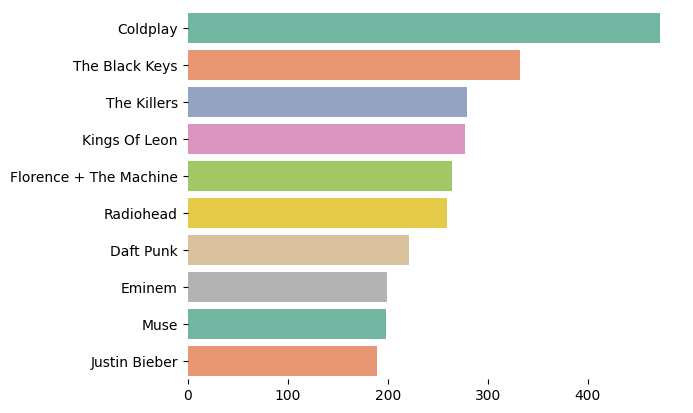

In [76]:
#count how many rows we have by artist name, we show only the ten more popular artist 
ten_pop_artists  = df_songs.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], ascending = [0,1])
ten_pop_artists = ten_pop_artists[:10]

plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

The maximum time the same user listened to the same songs was: 1890
On average, a user listen to the same song 2.9002 times


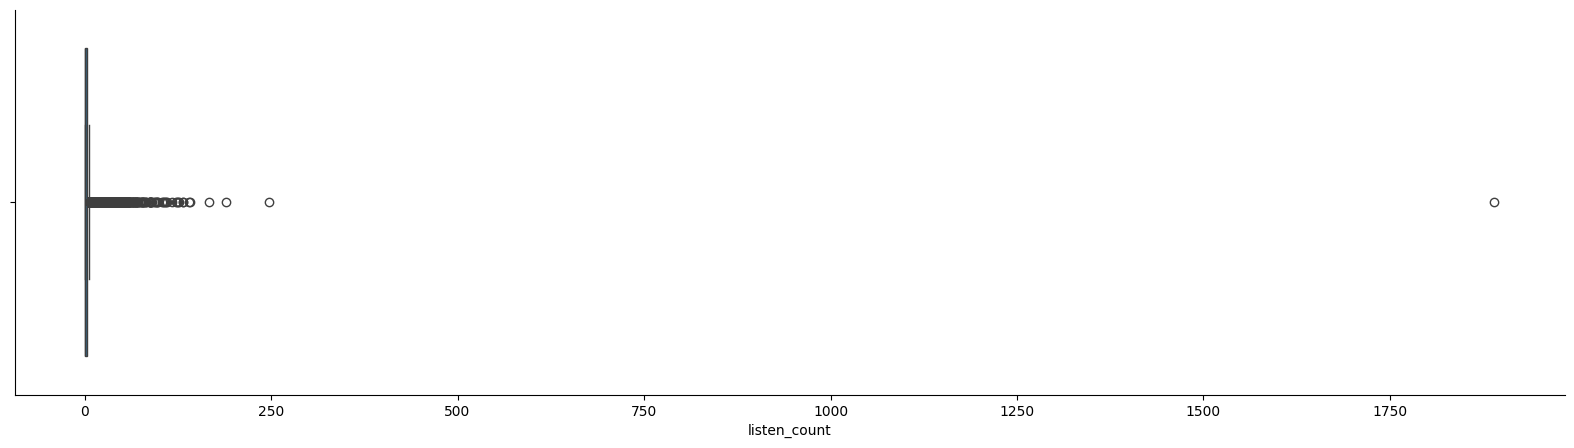

In [77]:
listen_counts = pd.DataFrame(df_songs.groupby('listen_count').size(), columns=['count'])
print(f"The maximum time the same user listened to the same songs was: {listen_counts.reset_index(drop=False)['listen_count'].iloc[-1]}")
print(f"On average, a user listen to the same song {df_songs['listen_count'].mean()} times")

plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=df_songs)
sns.despine()

In [93]:
# Get how many values should it be if all songs have been listen by all users
values_matrix = unique_users * unique_songs
# Substract the total values with the actural shape of the DataFrame songs
zero_values_matrix = values_matrix - df_songs.shape[0]
print(f"The matrix of users x songs has {zero_values_matrix} values that are zero")

The matrix of users x songs has 26063550 values that are zero


### Prepare the data

In [81]:
song_user = df_songs.groupby('user_id')['song_id'].count()
# Get users which have listen to at least 16 songs
song_ten_id = song_user[song_user > 16].index.to_list()
# Filtered the dataset to keep only those users with more than 16 listened
df_song_id_more_ten = df_songs[df_songs['user_id'].isin(song_ten_id)].reset_index(drop=True)


In [82]:
# convert the dataframe into a pivot table
df_songs_features = df_song_id_more_ten.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)

# obtain a sparse matrix
mat_songs_features = csr_matrix(df_songs_features.values)
# We need now to work with a `scipy-sparse matrix` to avoid overflow and wasted memory. For that purpose, we'll use the `csr_matrix` function from `scipy.sparse`.

In [83]:
# Mapping from id to song_name
df_unique_songs = df_songs.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'song_name']]

decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[df_songs_features.index].song_name))
}

### Model and recommendations

In [84]:
model = Recommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)
song = 'I believe in miracles'
new_recommendations = model.make_recommendation(new_song=song, n_recommendations=10)
print(f"The recommendations for {song} are:")
print(f"{new_recommendations}")

Starting the recommendation process for I believe in miracles ...
... Done
The recommendations for I believe in miracles are:
['Ooh Baby I Love You', 'Under The House', 'Another', "I'll Be Home On Tuesday (take 2)", 'People Get On Up', 'Warmer Places', 'How Am I Different', 'Sister Europe', 'Italian Skyline', 'Voice In Quartz']


# Matrix Factorization

In [87]:
# from surprise import SVD
# from surprise import Dataset, Reader
# from surprise import accuracy
# from surprise.model_selection import train_test_split
# from surprise.model_selection import GridSearchCV
# from surprise.model_selection import cross_validate

In [89]:
# df_songs = pd.read_csv('processed_songs.csv')
# song_user = df_songs.groupby('song_id')['user_id'].count()

# user_counts = df_songs.groupby('user_id')['song_id'].count()

# user_ten_id = user_counts[user_counts > 16].index.to_list()
# song_counts = df_songs.groupby('song_id')['user_id'].count()

# song_ten_id = song_counts[song_counts > 40].index.to_list()

# # Filtered the dataset to keep only those users with more than 16 listened and songs listened to 40 times
# df_song_reduced = df_songs[(df_songs['user_id'].isin(user_ten_id)) & (df_songs['song_id'].isin(song_ten_id))].reset_index(drop=True)

### Model and recommendations

Matrix Factorization is a powerful way to implement a recommendation system. The idea behind it is to represent users and items in a lower-dimensional latent space. 

So, in other words, Matrix factorization methods decompose the original sparse user-item matrix into lower dimensionality less sparse rectangular matrices with latent features.

This does not only solve the sparsity issue but also makes the method scalable. It doesn't matter how big the matrix is, you can always find lower dimensionality matrices that are a true representation of the original one.

Among the different matrix factorization techniques, we found the popular singular value decomposition (SVD).

This can be an abstract concept as we deepen into the mathematical foundations. But we'll try to keep it as simple as possible.
Imagine we have a matrix A that contains the data for n users x m songs. This matrix can be decomposed uniquely into 3 matrices; let's called them U, S, and V. 

In terms of our song recommender:

- U is an n users x r user-latent feature matrix
- V is an m songs x r song-latent feature matrix
- S is an r x r non-negative diagonal matrix containing the singular values of the original matrix.

Instead of working with the implicit rating as it is, we'll apply the binning technique.  
  
We'll define 10 categories. The original data values which fall into the interval from 0 to 1, will be replaced by the representative rating of 1; if they fall into the interval 1 to 2, they will be replaced by 2; and so on and so forth. The last category will be assigned to original values ranging from 9 to 2213.

In [91]:
# bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]
# df_song_reduced['listen_count'] = pd.cut(df_song_reduced['listen_count'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# listen_counts = pd.DataFrame(df_song_reduced.groupby('listen_count').size(), columns=['count']).reset_index(drop=False)

### Using Surprise for SVD

In [92]:
# reader = Reader(rating_scale=(1, 10))
# data = Dataset.load_from_df(df_song_reduced[['user_id', 'song_id', 'listen_count']], reader)

# # Split into training and testing
# trainset, testset = train_test_split(data, test_size=.25)

# param_grid = {'n_factors': [160], 
#     'n_epochs': [100], 
#     'lr_all': [0.001, 0.005],
#     'reg_all': [0.08, 0.1]}

# grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=4, n_jobs=-2)

# # find the best parameters for the model
# grid_search_svd.fit(data)
# find_algo = grid_search_svd.best_estimator['rmse']
# print(grid_search_svd.best_score['rmse'])
# print(grid_search_svd.best_params['rmse'])

# # Perform the cross validation
# cross_validate(find_algo, data, measures=['RMSE'], cv=5, verbose=True)

# final_algorithm = SVD(n_factors=160, n_epochs=100, lr_all=0.005, reg_all=0.1)
# final_algorithm.fit(trainset)
# test_predictions = final_algorithm.test(testset)
# print(f"The RMSE is {accuracy.rmse(test_predictions, verbose=True)}")


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  12 | elapsed:    7.5s remaining:   22.5s
[Parallel(n_jobs=-2)]: Done   7 out of  12 | elapsed:    7.5s remaining:    5.4s
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:    7.6s finished


2.5932817039999034
{'n_factors': 160, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.08}
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.6107  2.4276  2.6538  2.6180  2.6945  2.6009  0.0916  
Fit time          0.07    0.07    0.06    0.06    0.06    0.06    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
RMSE: 2.7080
The RMSE is 2.707971522396805
